In [146]:
import numpy as np
import random
from numpy.random import randn
from matplotlib import pyplot as plt

In [147]:
positives = 100
negatives = 50
signal_length = 15
max_pulse_length = 14

input_signals = np.zeros((positives + negatives,signal_length,1))
targets = np.zeros(positives + negatives,dtype=int)
for i in range(positives):
    targets[i] = 1
    pulse_length = random.randint(1,max_pulse_length+1)
    pulse_start = random.randint(0,signal_length - pulse_length)
    for j in range(pulse_length):
        input_signals[i][pulse_start+j][0] = 1


In [148]:
class LeakyRNN:
    
    # Modified from https://github.com/KTAswathi/IPB_2023/blob/main/IPB_lab3_BPTT.ipynb
    def __init__(self, input_size, output_size, ntc, hidden_size=64):
        # Weights
        self.Whh = randn(hidden_size, hidden_size) / 1000
        self.Wxh = randn(hidden_size, input_size) / 1000
        self.Why = randn(output_size, hidden_size) / 1000
    
        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

        # Neuronal time constant
        self.ntc = ntc
    
    def forward(self, inputs, neuromod):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        '''
        inputs = np.reshape(inputs,(inputs.shape[0],inputs.shape[1],1))
        h = np.zeros((self.Whh.shape[0], 1))
        self.last_inputs = inputs
        self.last_hs = { 0: h }
        # Perform each step of the RNN
        for i, x in enumerate(inputs):
            # Added leak and neuromodulator parameterised activation function
            h = h + self.ntc * (-h + neuro_activation(self.Wxh @ x + self.Whh @ h + self.bh,neuromod,np.tanh))
            self.last_hs[i + 1] = h
        
        # Compute the output
        y = self.Why @ h + self.by
        return y, h

    def backprop(self, d_y, learn_rate=2e-2):
        '''
        Perform a backward pass of the RNN.
        - d_y (dL/dy) has shape (output_size, 1).
        - learn_rate is a float.
        '''
        n = len(self.last_inputs)
    
        # Calculate dL/dWhy and dL/dby.
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y
    
        # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)
    
        # Calculate dL/dh for the last h.
        d_h = self.Why.T @ d_y
    
        # Backpropagate through time.
        for t in reversed(range(n)):
            # An intermediate value: dL/dh * (1 - h^2)
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)
            
            # dL/db = dL/dh * (1 - h^2)
            d_bh += temp
            
            # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
            d_Whh += temp @ self.last_hs[t].T
            
            # dL/dWxh = dL/dh * (1 - h^2) * x
            d_Wxh += temp @ self.last_inputs[t].T
            
            # Next dL/dh = dL/dh * (1 - h^2) * Whh
            d_h = self.Whh @ temp
    
        # Clip to prevent exploding gradients.
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d)
    
        # Update weights and biases using gradient descent.
        self.Whh -= learn_rate * d_Whh
        self.Wxh -= learn_rate * d_Wxh
        self.Why -= learn_rate * d_Why
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by

#Applies activation function scaled by neuromodulator
alpha = 1.0
def neuro_activation(x, n, func):
    return func(x * (alpha * n + np.ones(n.shape)))

def relu(x):
    return np.maximum(0,x)

In [149]:
def processData(input_data, targets, neuromods, rnn, lr=2e-2, backprop=True):
    '''
    Returns the RNN's loss and accuracy for the given data.
    - data is a dictionary mapping text to True or False.
    - backprop determines if the backward phase should be run.
    '''
    
    loss = 0
    num_correct = 0
    
    for i in range(len(input_data)):
        inputs = input_data[i]
        target = targets[i]
    
        # Forward
        out, _ = rnn.forward(inputs,neuromods)
        probs = softmax(out)
        
        # Calculate loss / accuracy
        loss -= np.log(probs[target])
        num_correct += int(np.argmax(probs) == target)
        
        if backprop:
            # Build dL/dy
            d_L_d_y = probs
            d_L_d_y[target] -= 1
            
            # Backward
            rnn.backprop(d_L_d_y,learn_rate=lr)
    
    return loss / len(input_data), num_correct / len(input_data)

In [150]:
h_size = 20
epochs = 800

def softmax(xs):
  # Applies the Softmax Function to the input array.
    return np.exp(xs) / sum(np.exp(xs))

loss_curves = []
acc_curves = []
test_loss_curves = []
test_acc_curves = []

perm = np.random.permutation(len(input_signals))
input_signals = input_signals[perm]
targets = targets[perm]

train_size = int(0.8 * len(input_signals))

train_input = input_signals[:train_size]
train_targets = targets[:train_size]
test_input = input_signals[train_size:]
test_targets = targets[train_size:]

rnns = []
nmodsets = []

perm = np.random.permutation(h_size)
for h in range(0,h_size+1,2):
    rnn = LeakyRNN(1,2,0.5,hidden_size=h_size)
    nmods = np.zeros((h_size,1))
    for i in range(h):
        nmods[i][0] = 1
    nmods = nmods[perm]
    nmodsets.append(nmods)
    loss = []
    acc = []
    test_losses = []
    test_accs = []
    for epoch in range(epochs):
      train_loss, train_acc = processData(train_input,train_targets,nmods,rnn,lr=0.001)
      test_loss, test_acc = processData(test_input, test_targets,nmods,rnn,backprop=False)

      loss.append(train_loss)
      acc.append(train_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)
      # if epoch % 10 == 9:
      #     print('--- Epoch %d' % (epoch + 1))
      #     print('Train:\tLoss %.3f | Accuracy: %.3f' % (train_loss, train_acc))
      if epoch == epochs-1:
          print(train_acc)
    acc_curves.append(acc)
    loss_curves.append(loss)
    test_loss_curves.append(test_losses)
    test_acc_curves.append(test_accs)
    rnns.append(rnn)
    
        
        #print('Test:\tLoss %.3f | Accuracy: %.3f' % (test_loss, test_acc))

0.9916666666666667
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


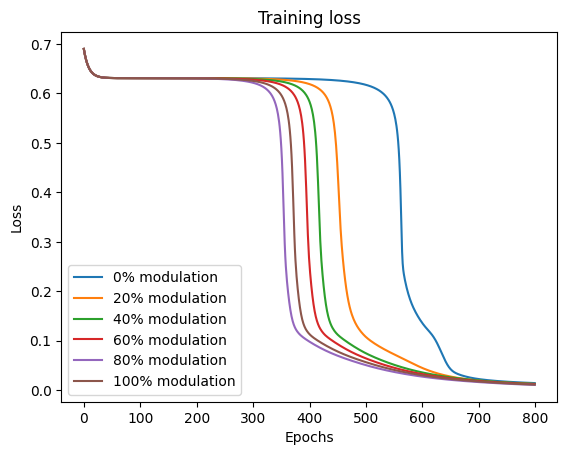

In [173]:
for l in range(0,len(loss_curves),2):
    plt.plot(np.arange(epochs),loss_curves[l],label=str(int((l/10)*100))+"% modulation")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

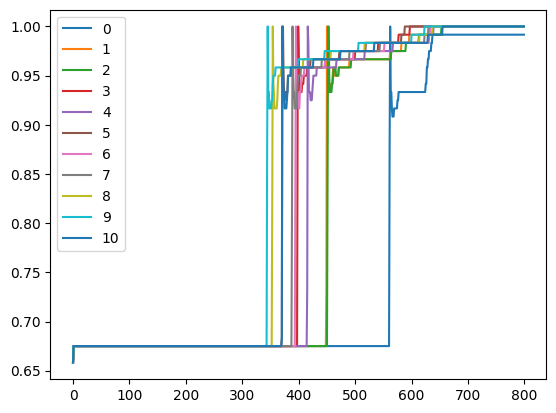

In [163]:
for l in range(len(acc_curves)):
    plt.plot(np.arange(epochs),acc_curves[l],label=str(l))
plt.legend()

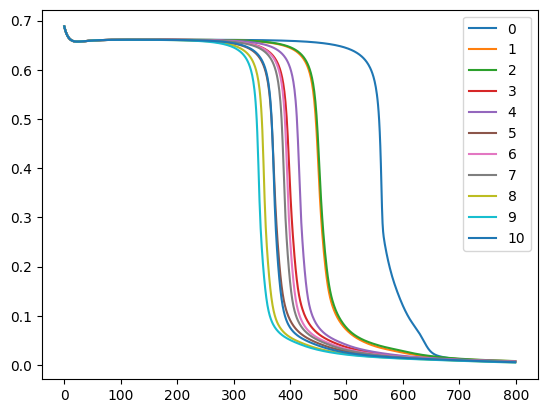

In [153]:
for l in range(len(test_loss_curves)):
    plt.plot(np.arange(epochs),test_loss_curves[l],label=str(l))
plt.legend()

Text(0.5, 1.0, 'Test accuracy')

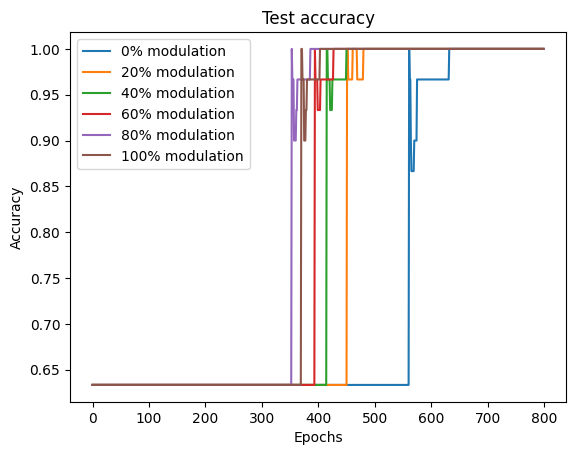

In [174]:
for l in range(0,len(test_acc_curves),2):
    plt.plot(np.arange(epochs),test_acc_curves[l],label=str(int((l/10)*100))+"% modulation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test accuracy")

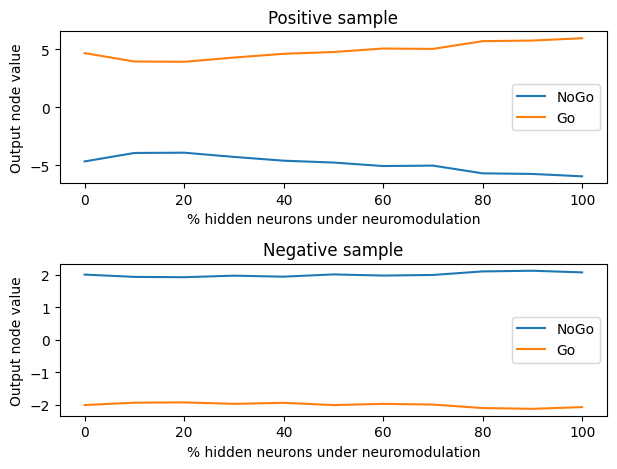

In [251]:
sample_true = np.array([[0],[0],[0],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
sample_false = np.zeros((15,1))
ts_out_neg = []
ts_out_pos = []
fs_out_neg = []
fs_out_pos = []

pos_hs = []
neg_hs = []

for i, rnn in enumerate(rnns):
    ts_out, pos_h = rnn.forward(sample_true,nmodsets[i])
    fs_out, neg_h = rnn.forward(sample_false,nmodsets[i])
    ts_out_neg.append(ts_out[0])
    ts_out_pos.append(ts_out[1])
    fs_out_neg.append(fs_out[0])
    fs_out_pos.append(fs_out[1])
    pos_hs.append(pos_h)
    neg_hs.append(neg_h)
    
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(np.arange(len(rnns)) * 10,ts_out_neg,label="NoGo")
ax1.plot(np.arange(len(rnns)) * 10,ts_out_pos,label="Go")
ax2.plot(np.arange(len(rnns)) * 10,fs_out_neg,label="NoGo")
ax2.plot(np.arange(len(rnns)) * 10,fs_out_pos,label="Go")
ax1.set_title("Positive sample")
ax2.set_title("Negative sample")
ax1.set_xlabel("% hidden neurons under neuromodulation")
ax2.set_xlabel("% hidden neurons under neuromodulation")
ax1.set_ylabel("Output node value")
ax2.set_ylabel("Output node value")
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

(array([8., 1., 0., 0., 0., 0., 0., 2., 1., 8.]),
 array([-0.92164952, -0.73664802, -0.55164652, -0.36664502, -0.18164352,
         0.00335798,  0.18835948,  0.37336098,  0.55836248,  0.74336398,
         0.92836548]),
 <BarContainer object of 10 artists>)

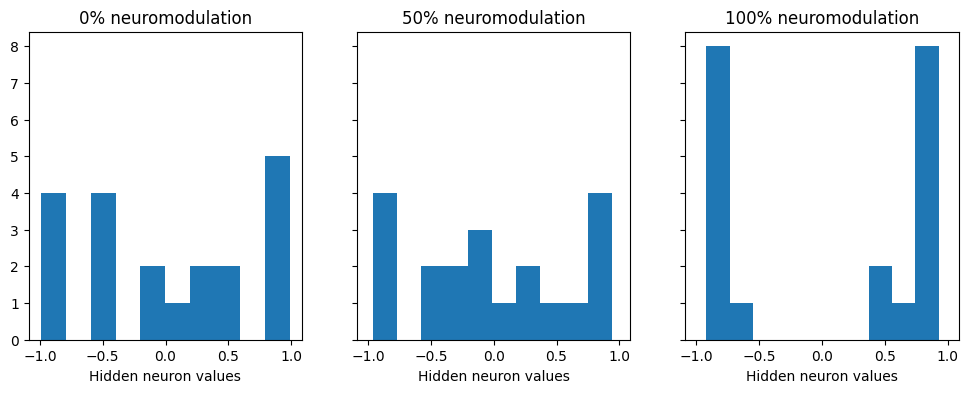

In [252]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
ax1.set_xlabel("Hidden neuron values")
ax2.set_xlabel("Hidden neuron values")
ax3.set_xlabel("Hidden neuron values")
ax1.set_title("0% neuromodulation")
ax2.set_title("50% neuromodulation")
ax3.set_title("100% neuromodulation")
ax1.hist(pos_hs[0])
ax2.hist(pos_hs[5])
ax3.hist(pos_hs[10])

(array([1., 1., 2., 1., 1., 7., 0., 1., 3., 3.]),
 array([-0.64974445, -0.52502539, -0.40030633, -0.27558727, -0.15086821,
        -0.02614915,  0.09856991,  0.22328897,  0.34800803,  0.47272709,
         0.59744615]),
 <BarContainer object of 10 artists>)

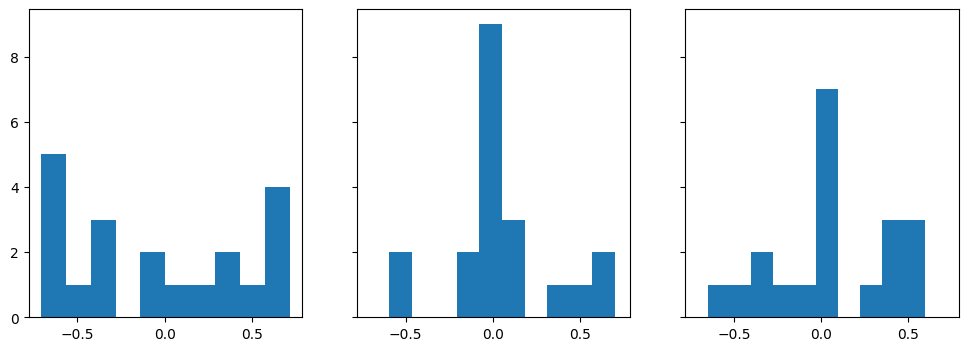

In [253]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
ax1.hist(neg_hs[0])
ax2.hist(neg_hs[5])
ax3.hist(neg_hs[10])

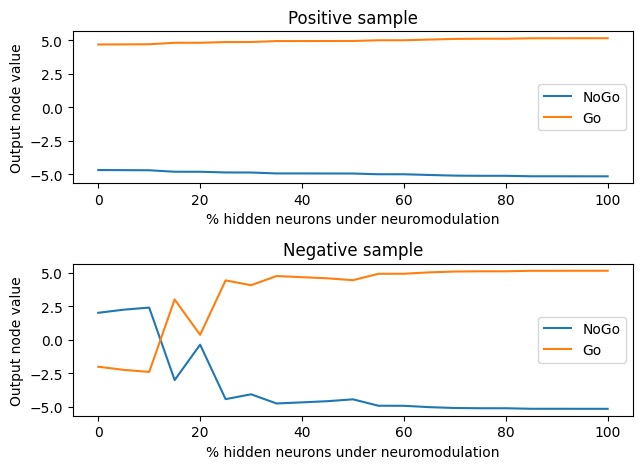

In [254]:
ts_out_neg = []
ts_out_pos = []
fs_out_neg = []
fs_out_pos = []

modded_test_accs = []
pos_hs = []
neg_hs = []

perm = np.random.permutation(h_size)
for h in range(h_size+1):
    nmods = np.zeros((h_size,1))
    for i in range(h):
        nmods[i][0] = 1
    nmods = nmods[perm]
    ts_out, pos_h = rnns[0].forward(sample_true,nmods)
    fs_out, neg_h = rnns[0].forward(sample_false,nmods)
    ts_out_neg.append(ts_out[0])
    ts_out_pos.append(ts_out[1])
    fs_out_neg.append(fs_out[0])
    fs_out_pos.append(fs_out[1])
    _, test_acc = processData(test_input,test_targets,nmods,rnns[0],backprop=False)
    modded_test_accs.append(test_acc)
    pos_hs.append(pos_h)
    neg_hs.append(neg_h)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(np.arange(h_size+1)/h_size * 100,ts_out_neg,label="NoGo")
ax1.plot(np.arange(h_size+1)/h_size * 100,ts_out_pos,label="Go")
ax2.plot(np.arange(h_size+1)/h_size * 100,fs_out_neg,label="NoGo")
ax2.plot(np.arange(h_size+1)/h_size * 100,fs_out_pos,label="Go")
ax1.set_title("Positive sample")
ax2.set_title("Negative sample")
ax1.set_xlabel("% hidden neurons under neuromodulation")
ax2.set_xlabel("% hidden neurons under neuromodulation")
ax1.set_ylabel("Output node value")
ax2.set_ylabel("Output node value")
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

(array([8., 0., 0., 0., 2., 0., 1., 0., 2., 7.]),
 array([-9.99532266e-01, -7.99626544e-01, -5.99720821e-01, -3.99815099e-01,
        -1.99909376e-01, -3.65361582e-06,  1.99902069e-01,  3.99807791e-01,
         5.99713514e-01,  7.99619236e-01,  9.99524959e-01]),
 <BarContainer object of 10 artists>)

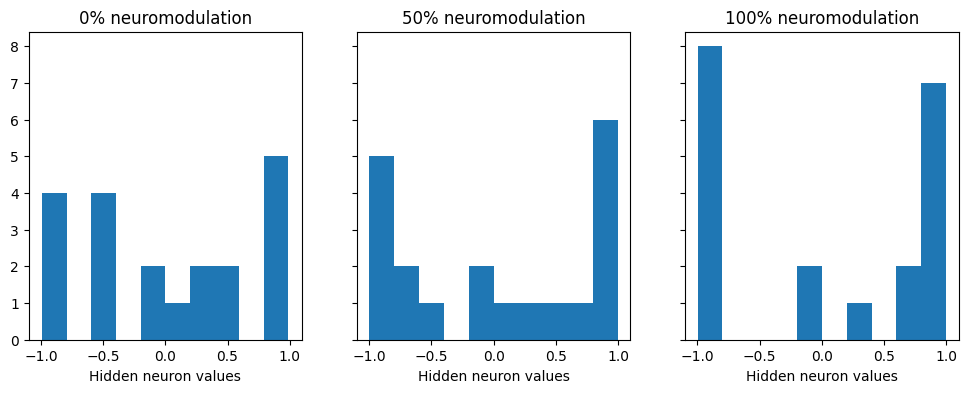

In [255]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
ax1.set_xlabel("Hidden neuron values")
ax2.set_xlabel("Hidden neuron values")
ax3.set_xlabel("Hidden neuron values")
ax1.set_title("0% neuromodulation")
ax2.set_title("50% neuromodulation")
ax3.set_title("100% neuromodulation")
ax1.hist(pos_hs[0])
ax2.hist(pos_hs[10])
ax3.hist(pos_hs[20])

(array([8., 0., 0., 0., 2., 0., 1., 0., 2., 7.]),
 array([-9.98535713e-01, -7.98831526e-01, -5.99127340e-01, -3.99423153e-01,
        -1.99718966e-01, -1.47793029e-05,  1.99689407e-01,  3.99393594e-01,
         5.99097781e-01,  7.98801968e-01,  9.98506154e-01]),
 <BarContainer object of 10 artists>)

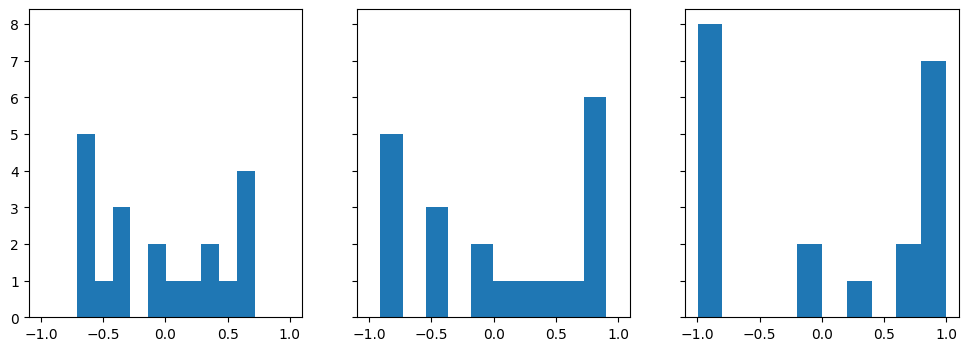

In [256]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
ax1.hist(neg_hs[0])
ax2.hist(neg_hs[10])
ax3.hist(neg_hs[20])

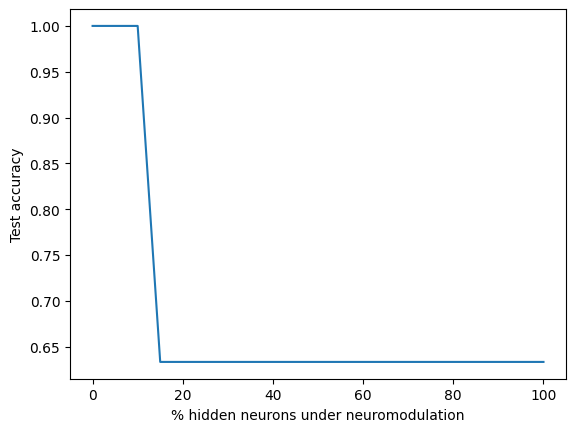

In [257]:
plt.plot(np.arange(h_size+1)/h_size * 100,modded_test_accs)
plt.xlabel("% hidden neurons under neuromodulation")
plt.ylabel("Test accuracy")
plt.show()

(array([  1.,   2.,   9.,   4., 202., 206.,   4.,   9.,   2.,   1.]),
 array([-7.45111278e-01, -5.96135512e-01, -4.47159746e-01, -2.98183980e-01,
        -1.49208214e-01, -2.32447717e-04,  1.48743318e-01,  2.97719084e-01,
         4.46694850e-01,  5.95670616e-01,  7.44646382e-01]),
 <BarContainer object of 10 artists>)

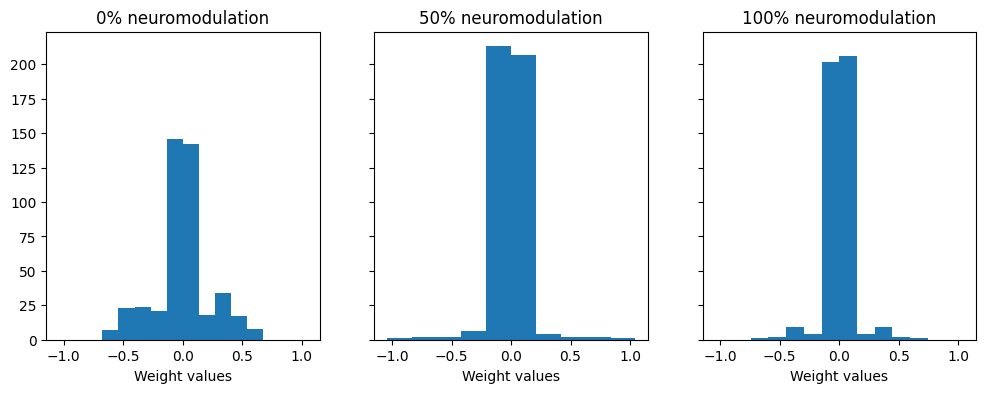

In [258]:
weights1 = np.concatenate((np.copy(rnns[0].Why).flatten(),np.copy(rnns[0].Whh).flatten()))
weights2 = np.concatenate((np.copy(rnns[5].Why).flatten(),np.copy(rnns[5].Whh).flatten()))
weights3 = np.concatenate((np.copy(rnns[10].Why).flatten(),np.copy(rnns[10].Whh).flatten()))
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
ax1.set_xlabel("Weight values")
ax2.set_xlabel("Weight values")
ax3.set_xlabel("Weight values")
ax1.set_title("0% neuromodulation")
ax2.set_title("50% neuromodulation")
ax3.set_title("100% neuromodulation")
ax1.hist(weights1)
ax2.hist(weights2)
ax3.hist(weights3)